In [56]:
import torch
from torchvision.datasets.utils import download_url
import pandas as pd

In [54]:
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

In [55]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [57]:
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

100%|██████████| 35735/35735 [00:00<00:00, 7635428.09it/s]


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [58]:
inputs = dataframe.drop('medv',axis = 1).values
targets = dataframe['medv'].values

In [59]:
inputs.shape,targets.shape

((506, 13), (506,))

In [60]:
batch_size = 64
learning_rate = 5e-7


In [88]:
# Convert to PyTorch dataset

dataset = TensorDataset(torch.tensor(inputs,dtype=torch.float32), torch.tensor(targets,dtype=torch.float32))

train_ds,val_ds = random_split(dataset,[406,100])

train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size*2)

## **Model**

In [89]:
import torch.nn as nn
import torch.nn.functional as F

In [90]:
class HousingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size,output_size)

  def forward(self,xb):
    output = self.linear(xb)
    return output

  def training_step(self,batch):
    inputs,targets = batch
    out = self(inputs)
    loss = F.mse_loss(out,targets)
    return loss

  def validation_step(self,batch):
    inputs,targets = batch
    out = self(inputs)
    loss = F.mse_loss(out,targets)
    return {'val_loss':loss.detach()}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # Combine losses

    return {'val_loss':epoch_loss.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch,result['val_loss']))

In [91]:
model = HousingModel()

In [95]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []

  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()

      optimizer.step() # gradient computation
      optimizer.zero_grad()

    result = evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)

  return history

In [96]:
result = evaluate(model,val_loader)
result

<ipython-input-90-30343a0a2bd7>:19: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out,targets)


{'val_loss': 13961.3759765625}

In [97]:
history = fit(10,learning_rate, model,train_loader,val_loader)

Epoch [0], val_loss: 241.7340
Epoch [1], val_loss: 174.4978
Epoch [2], val_loss: 172.0871
Epoch [3], val_loss: 168.5578
Epoch [4], val_loss: 170.0040
Epoch [5], val_loss: 167.0149
Epoch [6], val_loss: 163.7781
Epoch [7], val_loss: 162.6358
Epoch [8], val_loss: 161.6493
Epoch [9], val_loss: 160.2214


<ipython-input-90-30343a0a2bd7>:13: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out,targets)
<ipython-input-90-30343a0a2bd7>:13: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out,targets)
<ipython-input-90-30343a0a2bd7>:19: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out,targets)


In [112]:
history

[{'val_loss': 241.73402404785156},
 {'val_loss': 174.4977569580078},
 {'val_loss': 172.08712768554688},
 {'val_loss': 168.55780029296875},
 {'val_loss': 170.00396728515625},
 {'val_loss': 167.014892578125},
 {'val_loss': 163.77813720703125},
 {'val_loss': 162.6358184814453},
 {'val_loss': 161.64927673339844},
 {'val_loss': 160.22140502929688}]

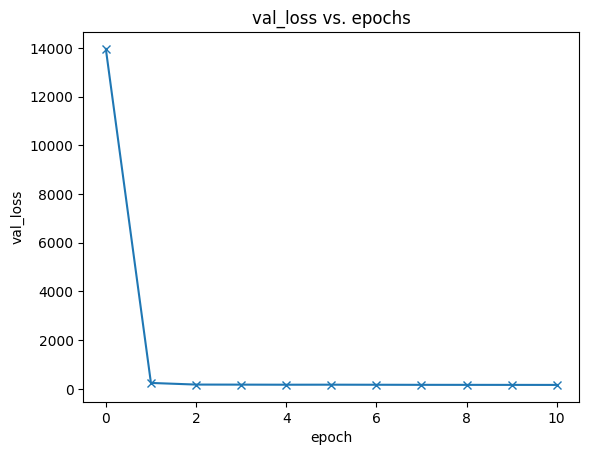

In [99]:
import matplotlib.pyplot as plt
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## **Prediction**

In [100]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [111]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([  0.5401,  20.0000,   3.9700,   0.0000,   0.6470,   7.2030,  81.8000,
          2.1121,   5.0000, 264.0000,  13.0000, 392.8000,   9.5900])
Target:  33.79999923706055
Prediction: 12.108678817749023
